Analyse afbeeldingen met python
===============================

Bestand: **Wilrijkse_plein.tiff** 
- Luchtfoto van sportcentrum Wilrijkse plein, te vogelzang Antwerpen. 4 banden: Rood (700 nm tot 580 nm), Groen (580 nm tot 500 nm), Blauw (500 nm tot 400 nm) en Nabij Infrarood (2500 nm tot 700 nm). Grootte is 640px op 640px, met een grondresolutie van 1 meter per pixel. 
- **bron:** *Orthofotomozaïek, middenschalig, zomeropnamen 2018 | Vlaamse overheid, Digitaal Vlaanderen (2018) | <https://download.vlaanderen.be/Producten/Detail?id=4465>*

Dependencies
------------
- matplotlib: `conda install -c conda-forge matplotlib`
- pillow: `conda install -c conda-forge pillow`
- numpy: `conda install -c conda-forge numpy`

In [2]:
from matplotlib import pyplot
from PIL import Image
import numpy as np

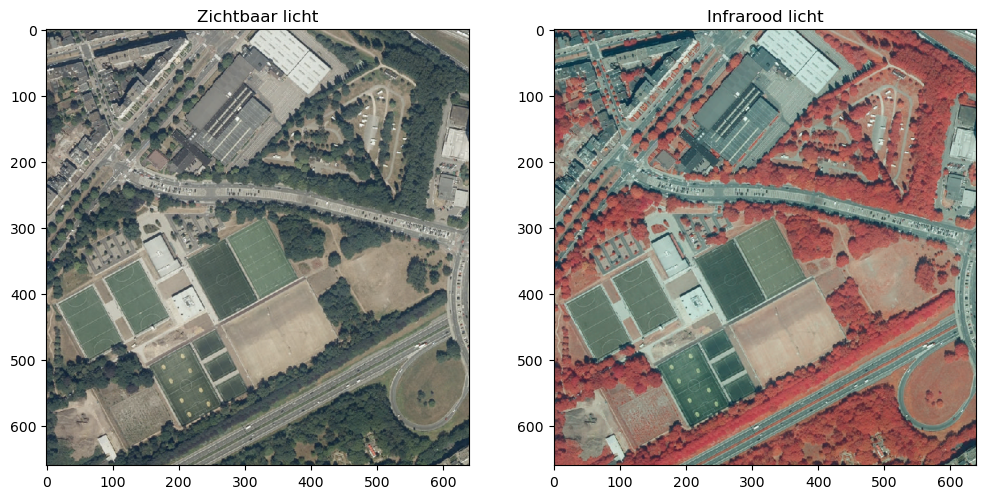

In [3]:
tiff = Image.open("data\Wilrijkse_plein.tiff")
im = np.array(tiff)
im_rgb = im[:,:,:3]  # rood, groen blauw
im_cir = im[:,:,[3,1,2]]  # NIR, groen blauw

# create figure
fig = pyplot.figure(figsize=(12, 7))

fig.add_subplot(1, 2, 1)
pyplot.imshow(im_rgb)
pyplot.title('Zichtbaar licht')

fig.add_subplot(1, 2, 2)
pyplot.imshow( im_cir )
pyplot.title('Infrarood licht')

pyplot.show()

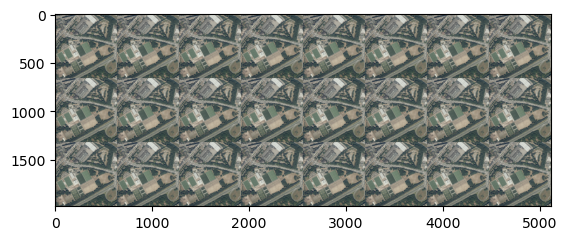

In [153]:
# oefening 1
img3x8 = np.tile(im_rgb, (3, 8, 1))
pyplot.imshow(img3x8) 
pyplot.show()

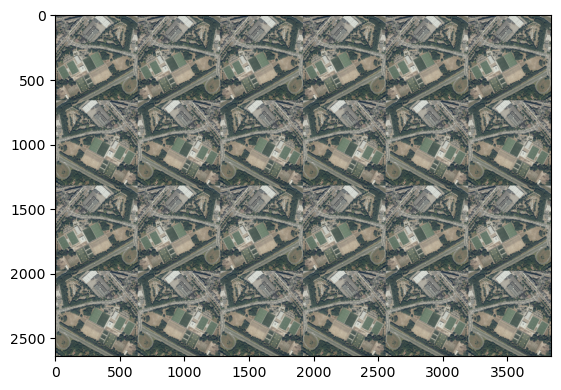

In [154]:
# oefening 2
im_flip_6x = np.tile( np.flip(im_rgb, axis=1) , (1,6,1)) 
im_rgb_6x = np.tile( im_rgb , (1,6,1)) 

pyplot.imshow(
    np.vstack( [ im_rgb_6x if n % 2 == 0 else im_flip_6x for n in range(4) ]) 
)
pyplot.show()

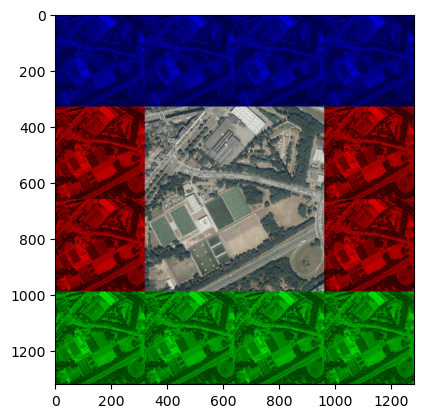

In [155]:
# oefening 3
zero_ = np.zeros([330, 320], dtype=int)

im_red =   np.stack( [im[::2,::2,0], zero_, zero_ ] , axis=2 )
im_green = np.stack( [zero_, im[::2,::2,1] , zero_] , axis=2 )
im_blue =  np.stack( [zero_, zero_, im[::2,::2,2] ] , axis=2 )

result=  np.vstack([
    np.hstack( [ im_blue, im_blue, im_blue, im_blue ]) ,
    np.hstack([
        np.vstack([im_red,im_red]),
        im_rgb, 
        np.vstack([im_red,im_red])
    ]),
    np.hstack( [ im_green, im_green, im_green, im_green]) ,
])
pyplot.imshow( result )
pyplot.show()

## Normalized Difference Vegetation Index (NDVI)

Planten (chlorophyll) absorberen sterk rood licht maar weerkaatsen  infrarood, dit laat toe vegetatie op een locatie in kaart te brengen. 
De waarde varieert tussen de -1 en de 1, waarbij positieve waardes groter dan 0.02 duiden op aanwezigheid van levende vegetatie. waarden groter dan 0.3 is dense vegetatie, meestal struiken of bomen. 

$NDVI = \frac{NIR - Rood}{NIR + Rood}$

We proberen dit uit met dit voorbeeld in Wilrijk. 

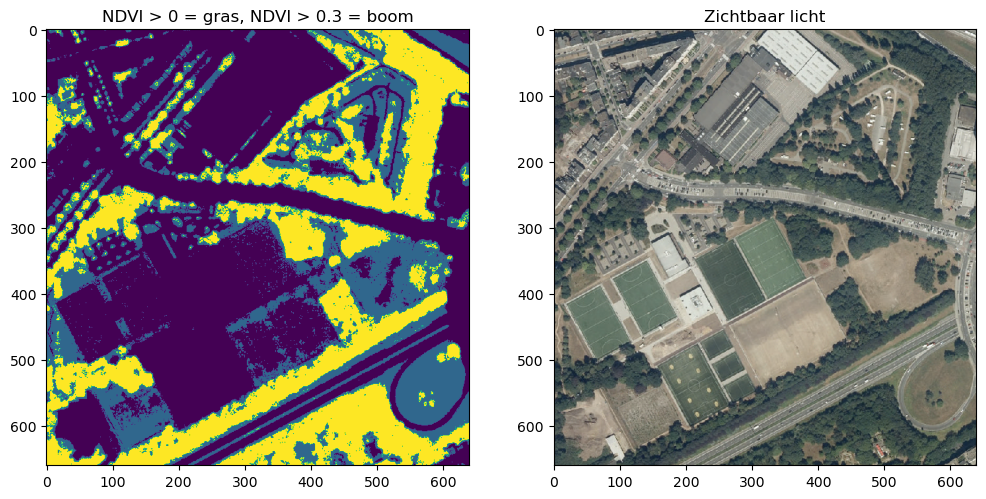

In [4]:
nir = im[:,:,3] *1.
red = im[:,:,0] *1.

ndvi = (nir - red) / (nir + red) 

fig = pyplot.figure(figsize=(12, 7))

fig.add_subplot(1, 2, 1)
pyplot.imshow( (ndvi > 0.02)*1 + (ndvi > 0.3)*2 )
pyplot.title('NDVI > 0 = gras, NDVI > 0.3 = boom')

fig.add_subplot(1, 2, 2)
pyplot.imshow( im_rgb )
pyplot.title('Zichtbaar licht')

pyplot.show()

#### Beerschot

Speel op echt gras

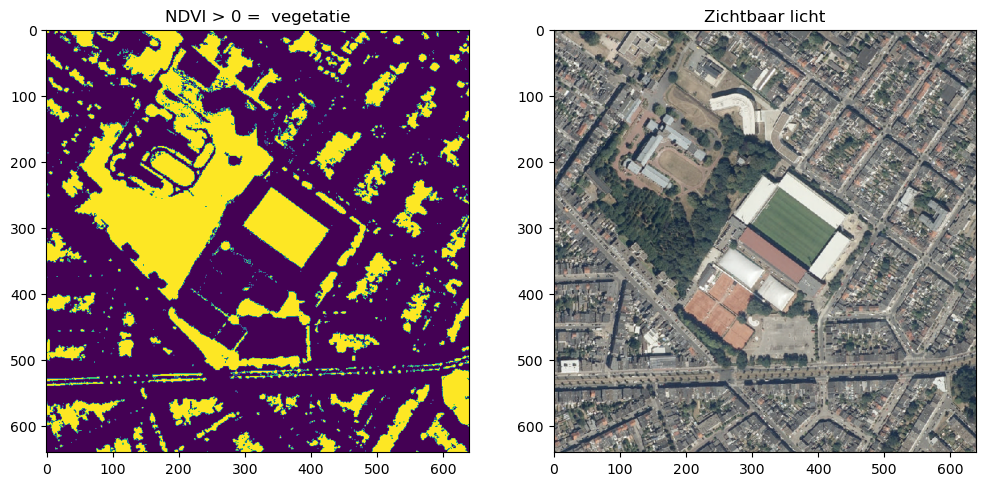

In [18]:
tiff = Image.open("data\Beerschot.tiff")
im = np.array(tiff)
im_rgb = im[:,:,:3]  # rood, groen blauw
im_cir = im[:,:,[3,1,2]]  # NIR, groen blauw

nir = im[:,:,3] *1.
red = im[:,:,0] *1.

ndvi = (nir - red) / (nir + red) 

fig = pyplot.figure(figsize=(12, 7))

fig.add_subplot(1, 2, 1)
pyplot.imshow( (ndvi > 0.02) )
pyplot.title('NDVI > 0 =  vegetatie')

fig.add_subplot(1, 2, 2)
pyplot.imshow( im_rgb )
pyplot.title('Zichtbaar licht')

pyplot.show()

### Convolutie filter, rand detectie, valse schaduw

Herkennen van randen in afbeelding of valse schaduw te creëren. <br>
Dit is nuttig om zaken zichtbaar te maken die je op een gewone afbeelding niet ziet. 

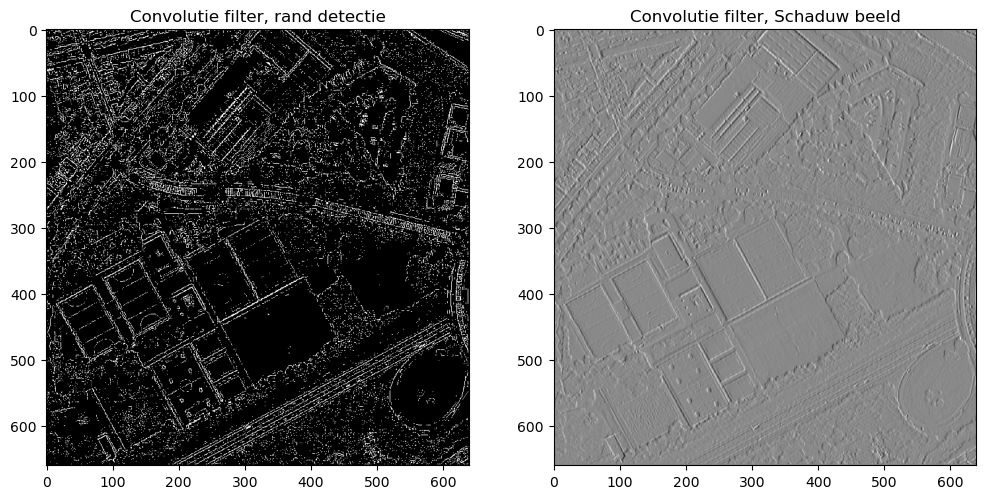

In [5]:
pan = np.mean(im, axis=2)  

def conv2d(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

edge_filter = np.array([[-1,-1,-1],
                        [-1, 8,-1],
                        [-1,-1,-1]])

shadow_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]])

# create figure
fig = pyplot.figure(figsize=(12, 7))

fig.add_subplot(1,2, 1)
edge = np.pad( conv2d(pan, edge_filter) , 1)
pyplot.imshow(  edge > 100 , cmap='gray' )
pyplot.title('Convolutie filter, rand detectie')

fig.add_subplot(1,2, 2)
shadow = np.pad( conv2d(pan, shadow_filter) , 1)
pyplot.imshow( shadow, cmap='gray')
pyplot.title('Convolutie filter, Schaduw beeld')

pyplot.show()